<a href="https://colab.research.google.com/github/nabiafshan/lncrna_reproduce/blob/main/simulation/weighing_by_epoch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
import pickle
import pathlib

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [109]:
modelDir = pathlib.Path('/content/drive/My Drive/00Projects/rna_coding_potential/models/')
dataDir = pathlib.Path('/content/drive/My Drive/00Projects/rna_coding_potential/data/')
figDir = pathlib.Path('/content/drive/My Drive/00Projects/rna_coding_potential/figures/')

In [86]:
def weighted_avg_and_std(values, weights, axis=1):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights, axis=axis)
    average_2d = np.reshape(average, (-1, 1))
    # Fast and numerically precise:
    variance = np.average((values-average_2d)**2, weights=weights, axis=axis)
    return (average, np.sqrt(variance))

In [87]:
def is_mislabelled(row: pd.Series, mean_col: str, sd_col: str, mean_limit: float = 0.6, sd_limit: float = 0.4):
    if float(row[mean_col]) <= mean_limit and float(row[sd_col]) <= sd_limit:
        return 'identified'
    else:
        return 'not identified'
def get_sim_mean(row):
    mu = row['index'].split('_')[1]
    return float(mu[:3])
def get_sim_sd(row):
    sd = row['index'].split('_')[2]
    return float(sd[:3])
def get_sim_flip_percent(row):
    flip = row['index'].split('_')[0]
    if len(flip) > 8:
        return int(flip[0:2])
    else:
        return int(flip[0])
def get_sim_threshold(row):
    th = row['index'].split('-')[-1]
    return th
def get_mean_cutoff(row):
    mu = row['index'].split('_')[4]
    return float(mu[:3])
def get_sd_cutoff(row):
    sd = row['index'].split('_')[5]
    return float(sd[:3])

## Simulation data

In [76]:
mean_cutoffs = [0.6, 0.5, 0.4]
sd_cutoffs = [0.3, 0.4]
sim_params = [[1, 0.6, 0.3, 27],
              [1, 0.6, 0.3, 28],
              [1, 0.7, 0.1, 8],
              [1, 0.6, 0.3, 27],
              [1, 0.7, 0.2, 7],
              [1, 0.8, 0.1, 8],
              [5, 0.6, 0.3, 30],
              [5, 0.6, 0.3, 31],
              [5, 0.6, 0.3, 32],
              [5, 0.7, 0.1, 6],
              [5, 0.7, 0.2, 6],
              [5, 0.7, 0.3, 1],
              [5, 0.8, 0.1, 2],
              [5, 0.8, 0.2, 2],
              [10, 0.6, 0.3, 17],
              [10, 0.6, 0.3, 18],
              [10, 0.6, 0.3, 19],
              [10, 0.7, 0.1, 5],
              [10, 0.7, 0.2, 3]]
thresholds = ['base', 'weighted', 'ignore_1st_0.05', 'ignore_1st_0.1', 
              'ignore_1st_0.2', 'ignore_1st_0.4', 'ignore_1st_0.6', 'ignore_1st_0.8']
results = {}

for mean_cutoff in mean_cutoffs:
  for sd_cutoff in sd_cutoffs:
    for i, param_set in enumerate(sim_params):
      percent = param_set[0]
      mean = param_set[1]
      sd = param_set[2]
      run = param_set[3]

      # determine file names
      preds_fname = f'predhis_train_lstm_flip_{str(percent)}percent_{str(mean)}mean_{str(sd)}sd_{str(run)}run.pickle'
      preds_ids_train = f'ids_train_lstm_flip_{str(percent)}percent_{str(mean)}mean_{str(sd)}sd_{str(run)}run.pickle'
      preds_csv_file = f'flipped_{str(percent)}percent_{str(mean)}mean_{str(sd)}sd_{str(run)}run_trainPredhis_lastEpochs.csv'

      # read files
      with open(modelDir / preds_fname, 'rb') as f:
          pred_his = pickle.load(f)
      with open(modelDir / preds_ids_train, 'rb') as f:
          pred_his_ids = pickle.load(f)
      preds_csv = pd.read_csv(modelDir / preds_csv_file)
      details = preds_csv[['id', 'gold_lab', 'flip', 'unflip_gold_lab']].copy()

      # ground truth labels
      pred_his_ids = list(pred_his_ids)
      pred_his_true = np.array([0 if "NM" in e else 1 for e in pred_his_ids])

      # ignore first x percent epochs
      percents = [0, 5/100, 10/100, 20/100, 40/100, 60/100, 80/100]

      n_values = np.max(pred_his_true) + 1
      mask = np.eye(n_values)[pred_his_true]

      for ignore_epochs_percent in percents:
        ignore_epochs_num = int(np.ceil(ignore_epochs_percent * len(pred_his)))

        for epoch in range(ignore_epochs_num, len(pred_his)):
          thisEpochProbs = pred_his[epoch]
          # For mean, sd
          thisMaskedProbs = (thisEpochProbs * mask).sum(axis = 1).reshape(-1, 1)   
          # Save
          if epoch == ignore_epochs_num:
            allEpochClassProbs = thisMaskedProbs
          elif epoch > ignore_epochs_num:
            allEpochClassProbs = np.hstack((allEpochClassProbs, thisMaskedProbs))
        ignored_epochs_mean = np.average(allEpochClassProbs, axis=1)
        ignored_epochs_sd = np.std(allEpochClassProbs, axis=1)

        if ignore_epochs_percent == 0:
          weights = np.arange(1, len(pred_his)+1 ) / len(pred_his)
          new_mean, new_sd = weighted_avg_and_std(allEpochClassProbs, weights)
          details['base_mean'] = ignored_epochs_mean
          details['base_sd'] = ignored_epochs_sd
          details['weighted_mean'] = new_mean
          details['weighted_sd'] = new_sd
        else:
          mean_col_name = f'ignore_1st_{ignore_epochs_percent}_mean'
          sd_col_name = f'ignore_1st_{ignore_epochs_percent}_sd'
          details[mean_col_name] = ignored_epochs_mean
          details[sd_col_name] = ignored_epochs_sd
      
      flipped = details[details['flip'] == 1].copy()
      for threshold in thresholds:
        this_result_name = f'{str(percent)}percent_{str(mean)}mean_{str(sd)}sd_{str(run)}run_{mean_cutoff}meancutoff_{sd_cutoff}sdcutoff-{threshold}'
        this_new_col_name = f'is_mislabelled_{threshold}'
        this_mean_col_name = f'{threshold}_mean'
        this_sd_col_name = f'{threshold}_sd'
        flipped[this_new_col_name] = flipped.apply(
          lambda row: is_mislabelled(row, this_mean_col_name, this_sd_col_name, mean_cutoff, sd_cutoff), axis=1)
        results[this_result_name] = flipped[this_new_col_name].value_counts(normalize=True)
  


In [77]:
results_df = pd.DataFrame(results).T.reset_index()
results_df['mean_cutoff'] = results_df.apply(lambda row: get_mean_cutoff(row), axis=1)
results_df['sd_cutoff'] = results_df.apply(lambda row: get_sd_cutoff(row), axis=1)
results_df['sim_mean'] = results_df.apply(lambda row: get_sim_mean(row), axis=1)
results_df['sim_sd'] = results_df.apply(lambda row: get_sim_sd(row), axis=1)
results_df['sim_flip_percent'] = results_df.apply(lambda row: get_sim_flip_percent(row), axis=1)
results_df['threshold'] = results_df.apply(lambda row: get_sim_threshold(row), axis=1)

In [78]:
results_df

,index,identified,not identified,mean_cutoff,sd_cutoff,sim_mean,sim_sd,sim_flip_percent,threshold
0,1percent_0.6mean_0.3sd_27run_0.6meancutoff_0.3...,0.979554,0.020446,0.6,0.3,0.6,0.3,1,base
1,1percent_0.6mean_0.3sd_27run_0.6meancutoff_0.3...,0.970260,0.029740,0.6,0.3,0.6,0.3,1,weighted
2,1percent_0.6mean_0.3sd_27run_0.6meancutoff_0.3...,0.977695,0.022305,0.6,0.3,0.6,0.3,1,ignore_1st_0.05
3,1percent_0.6mean_0.3sd_27run_0.6meancutoff_0.3...,0.977695,0.022305,0.6,0.3,0.6,0.3,1,ignore_1st_0.1
4,1percent_0.6mean_0.3sd_27run_0.6meancutoff_0.3...,0.973978,0.026022,0.6,0.3,0.6,0.3,1,ignore_1st_0.2
...,...,...,...,...,...,...,...,...,...
859,10percent_0.7mean_0.2sd_3run_0.4meancutoff_0.4...,0.938916,0.061084,0.4,0.4,0.7,0.2,10,ignore_1st_0.1
860,10percent_0.7mean_0.2sd_3run_0.4meancutoff_0.4...,0.939101,0.060899,0.4,0.4,0.7,0.2,10,ignore_1st_0.2
861,10percent_0.7mean_0.2sd_3run_0.4meancutoff_0.4...,0.936131,0.063869,0.4,0.4,0.7,0.2,10,ignore_1st_0.4
862,10percent_0.7mean_0.2sd_3run_0.4meancutoff_0.4...,0.932046,0.067954,0.4,0.4,0.7,0.2,10,ignore_1st_0.6


In [89]:
# with open(dataDir / 'sims_cutoffs_thresholds.pickle', 'wb') as handle:
#     pickle.dump(results_df, handle)

with open(dataDir / 'sims_cutoffs_thresholds.pickle', 'rb') as handle:
    results_df = pickle.load(handle)

In [90]:
mult = results_df.drop(columns=['index'], axis=1).groupby(['mean_cutoff', 'sd_cutoff', 'threshold'])['not identified'].agg(['mean', 'std'])
mult = mult.sort_values('mean')

In [107]:
colors = []
for e in list(mult.reset_index()['threshold']):
  if 'base' in e:
    colors.append('rosybrown')
  elif 'weighted' in e:
    colors.append('dimgrey')
  else:
    colors.append('gainsboro')

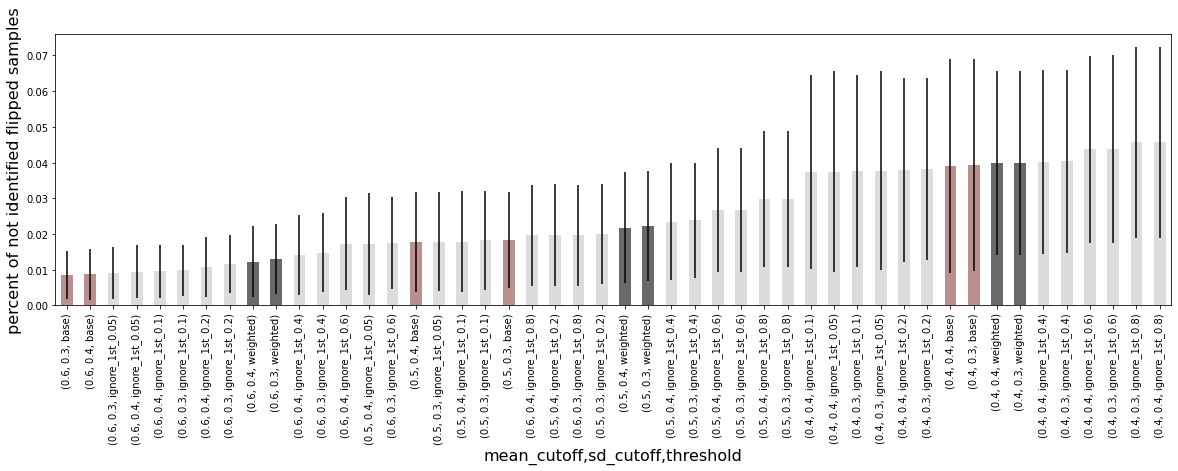

In [110]:
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16

mult['mean'].plot.bar(yerr=mult['std'], figsize=(20,5), color=colors)
plt.ylabel('percent of not identified flipped samples')
plt.savefig(figDir / 'sim_weighing_epochs.pdf', bbox_inches='tight')


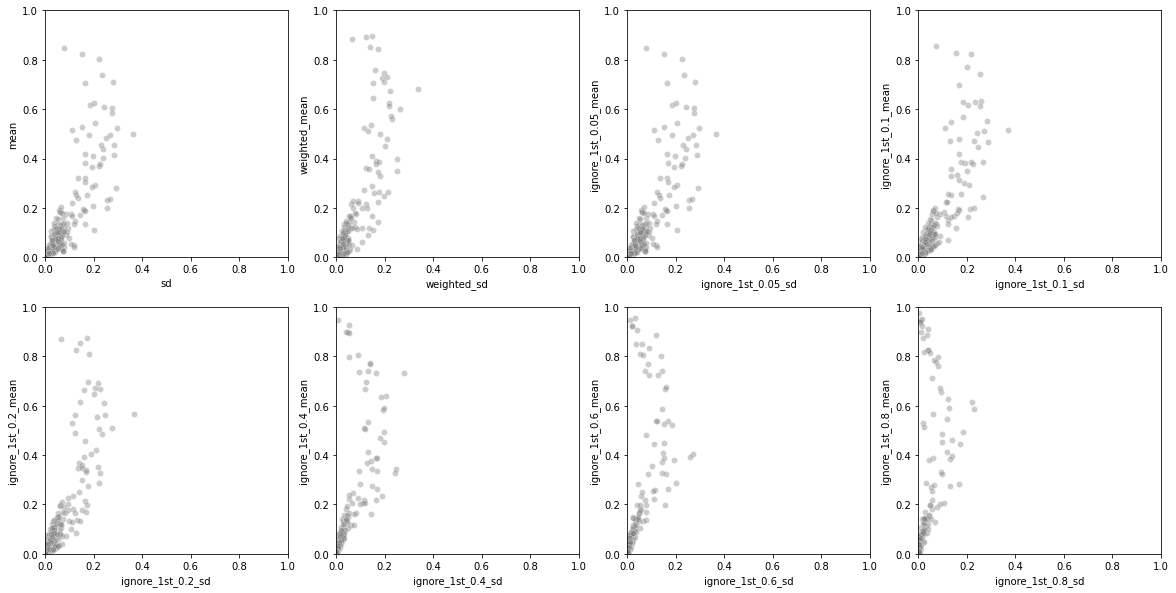

In [ ]:
# data = details[details['flip']==1]
# fig, axes = plt.subplots(nrows=2, ncols=4, sharex=False, sharey=False, figsize=(20, 10))
# sns.scatterplot(data=data, x='sd', y='mean', alpha=0.4, ax=axes[0, 0], color='grey')
# sns.scatterplot(data=data, x='weighted_sd', y='weighted_mean', alpha=0.4, ax=axes[0, 1], color='grey')
# sns.scatterplot(data=data, x='ignore_1st_0.05_sd', y='ignore_1st_0.05_mean', alpha=0.4, ax=axes[0, 2], color='grey')
# sns.scatterplot(data=data, x='ignore_1st_0.1_sd', y='ignore_1st_0.1_mean', alpha=0.4, ax=axes[0, 3], color='grey')
# sns.scatterplot(data=data, x='ignore_1st_0.2_sd', y='ignore_1st_0.2_mean', alpha=0.4, ax=axes[1, 0], color='grey')
# sns.scatterplot(data=data, x='ignore_1st_0.4_sd', y='ignore_1st_0.4_mean', alpha=0.4, ax=axes[1, 1], color='grey')
# sns.scatterplot(data=data, x='ignore_1st_0.6_sd', y='ignore_1st_0.6_mean', alpha=0.4, ax=axes[1, 2], color='grey')
# sns.scatterplot(data=data, x='ignore_1st_0.8_sd', y='ignore_1st_0.8_mean', alpha=0.4, ax=axes[1, 3], color='grey')
# plt.setp(axes, ylim=(0,1), xlim=(0,1))
# plt.savefig(f'weighing_epochs_{percent}percent_{mean}mean_{sd}sd_{run}run.pdf', bbox_inches='tight')

In [ ]:
# with flipped samples, i want to try different schemes of identifying misannotated samples
# then i want to be able to judge which scheme is the best
# as we were, weighing by epoch, ignoring first few epochs (different thresholds) 

# find the location of the prediction histories, where are those pickles?

# the next thing to do is to calculate stats for all these files.
# have a look at how i did it previously from the github repo. use same/similar code to caculate similar stats

# i want to do the identification for mean and sd to use for iding misannotated samples according to data. 
# atm. i'm using 0.6 and 0.4